# SimpleRNN을 이용한 SMS Spam 분류
- kaggle download: https://www.kaggle.com/uciml/sms-spam-collection-dataset
- 참고: https://www.kaggle.com/faizanshaikh3033/sms-spam

In [3]:
from google.colab import files
up = files.upload()

Saving spam.csv to spam.csv


In [23]:
import pandas as pd
df = pd.read_csv('spam.csv', encoding='latin1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [24]:
# Unnamed1, Unnamed2, Unnamed3 제거
# Selection
# df = df[['v1', 'v2']]
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
df.head(3)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [25]:
# Null 있으면 제거
df.isnull().sum()

v1    0
v2    0
dtype: int64

In [26]:
# 중복 데이터 제거: df.v2.nunique() 사용해야함!
df.shape, df.nunique().sum()

((5572, 2), 5171)

In [39]:
# df.drop_duplicates(subset=['v2'], inplace=True)
df.drop_duplicates('v2', inplace=True)
df.shape

(5169, 2)

In [40]:
# ['ham', 'spam'] --> [0,1]
df.v1 = df.v1.replace(['ham', 'spam'], [0,1])
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [44]:
# Ham / Spam 갯수
df.v1.value_counts()

0    4516
1     653
Name: v1, dtype: int64

In [82]:
df.to_csv('spam_전처리완료.csv', index=False, )

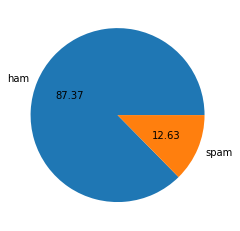

In [63]:
import matplotlib.pyplot as plt

plt.pie(df.v1.value_counts(), labels=['ham', 'spam'], autopct='%0.2f')
plt.show()

In [49]:
# x, y data
x = df.v2.values
y = df.v1.values
x.shape, y.shape

((5169,), (5169,))

### 텍스트 전처리

In [50]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [56]:
# 구둣점 제거, 소문자 변환
import re

def preprocessing(s):
    s = s.encode('utf8').decode('ascii', 'ignore')
    s = re.sub('[^a-z0-9 ]', '', s.lower())
    return s

In [57]:
X_data = [preprocessing(sent) for sent in x]
X_data[2]

'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s'

In [60]:
# 단어 집합을 만들고, 그 크기를 확인
t = Tokenizer()
t.fit_on_texts(X_data)
vocab_size = len(t.word_index) + 1
vocab_size

9479

In [64]:
sequences = t.texts_to_sequences(X_data)
print(sequences[2])

[54, 508, 8, 22, 4, 959, 960, 2, 217, 2566, 1291, 664, 2567, 2568, 268, 2569, 71, 2566, 2, 2570, 2, 336, 508, 3839, 84, 3840, 424, 3841]


In [66]:
max_len = max(len(seq) for seq in sequences)
max_len

171

In [67]:
# 전체 데이터셋의 길이를 max_len에 맞추고, 0 padding을 해줌
data = pad_sequences(sequences, maxlen=max_len, padding='pre')

- Train/test dataset 분리

In [70]:
import numpy as np
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [71]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data, y, stratify=y, test_size=0.2, random_state=2022
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4135, 171), (1034, 171), (4135,), (1034,))

- 모델 정의/설정/학습

In [73]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [74]:
model = Sequential([ 
    Embedding(vocab_size, 32, input_length=max_len),
    SimpleRNN(32, activation='tanh'),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 171, 32)           303328    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 305,441
Trainable params: 305,441
Non-trainable params: 0
_________________________________________________________________


In [75]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [76]:
model_path = 'best-spam.h5'
checkpoint = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
early_stop = EarlyStopping(patience=10)

In [77]:
hist = model.fit(X_train, y_train, epochs=100, batch_size=64, 
                 validation_split=0.2, callbacks=[checkpoint, early_stop])

Epoch 1/100
52/52 [==============================] - ETA: 0s - loss: 0.4025 - accuracy: 0.8558
Epoch 00001: val_loss improved from inf to 0.24655, saving model to best-spam.h5
52/52 [==============================] - 6s 75ms/step - loss: 0.4025 - accuracy: 0.8558 - val_loss: 0.2466 - val_accuracy: 0.8984
Epoch 2/100
52/52 [==============================] - ETA: 0s - loss: 0.1692 - accuracy: 0.9516
Epoch 00002: val_loss improved from 0.24655 to 0.12406, saving model to best-spam.h5
52/52 [==============================] - 3s 67ms/step - loss: 0.1692 - accuracy: 0.9516 - val_loss: 0.1241 - val_accuracy: 0.9686
Epoch 3/100
52/52 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9843
Epoch 00003: val_loss improved from 0.12406 to 0.09715, saving model to best-spam.h5
52/52 [==============================] - 4s 69ms/step - loss: 0.0723 - accuracy: 0.9843 - val_loss: 0.0972 - val_accuracy: 0.9698
Epoch 4/100
52/52 [==============================] - ETA: 0s - loss: 0.037

In [78]:
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

33/33 [==============================] - 1s 13ms/step - loss: 0.0796 - accuracy: 0.9749


[0.07961336523294449, 0.9748549461364746]

- 훈련과정 시각화

In [79]:
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

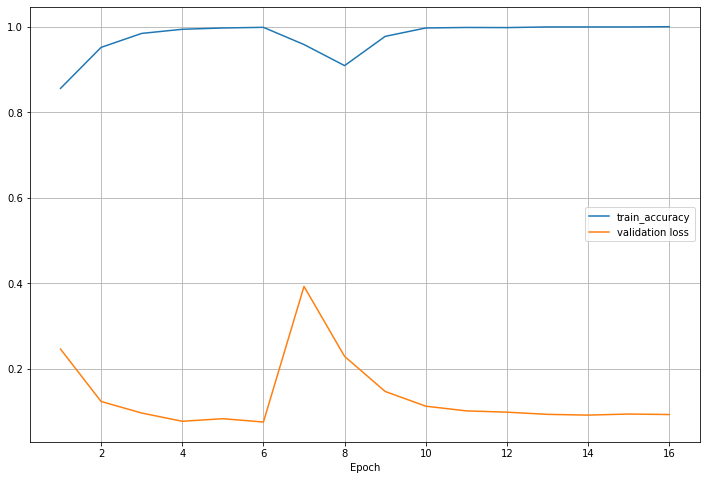

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='train_accuracy')
plt.plot(xs, y_vloss, label='validation loss')
plt.xlabel('Epoch')
plt.grid(), plt.legend()
plt.show()